YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JAPAULGOLD.LG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data found with yfinance. In a real scenario, you would need to:
1. Use a different data provider that covers NGX
2. Import CSV data manually from a Nigerian broker
Creating sample data for demonstration...
Sample data created for demonstration
Performance Summary:
Total Trades: 8.0
Win Rate: 12.50%
Max Drawdown: -1.81%
Sharpe Ratio: -0.58
Final Strategy Return: 98.66%
Buy & Hold Return: 99.94%


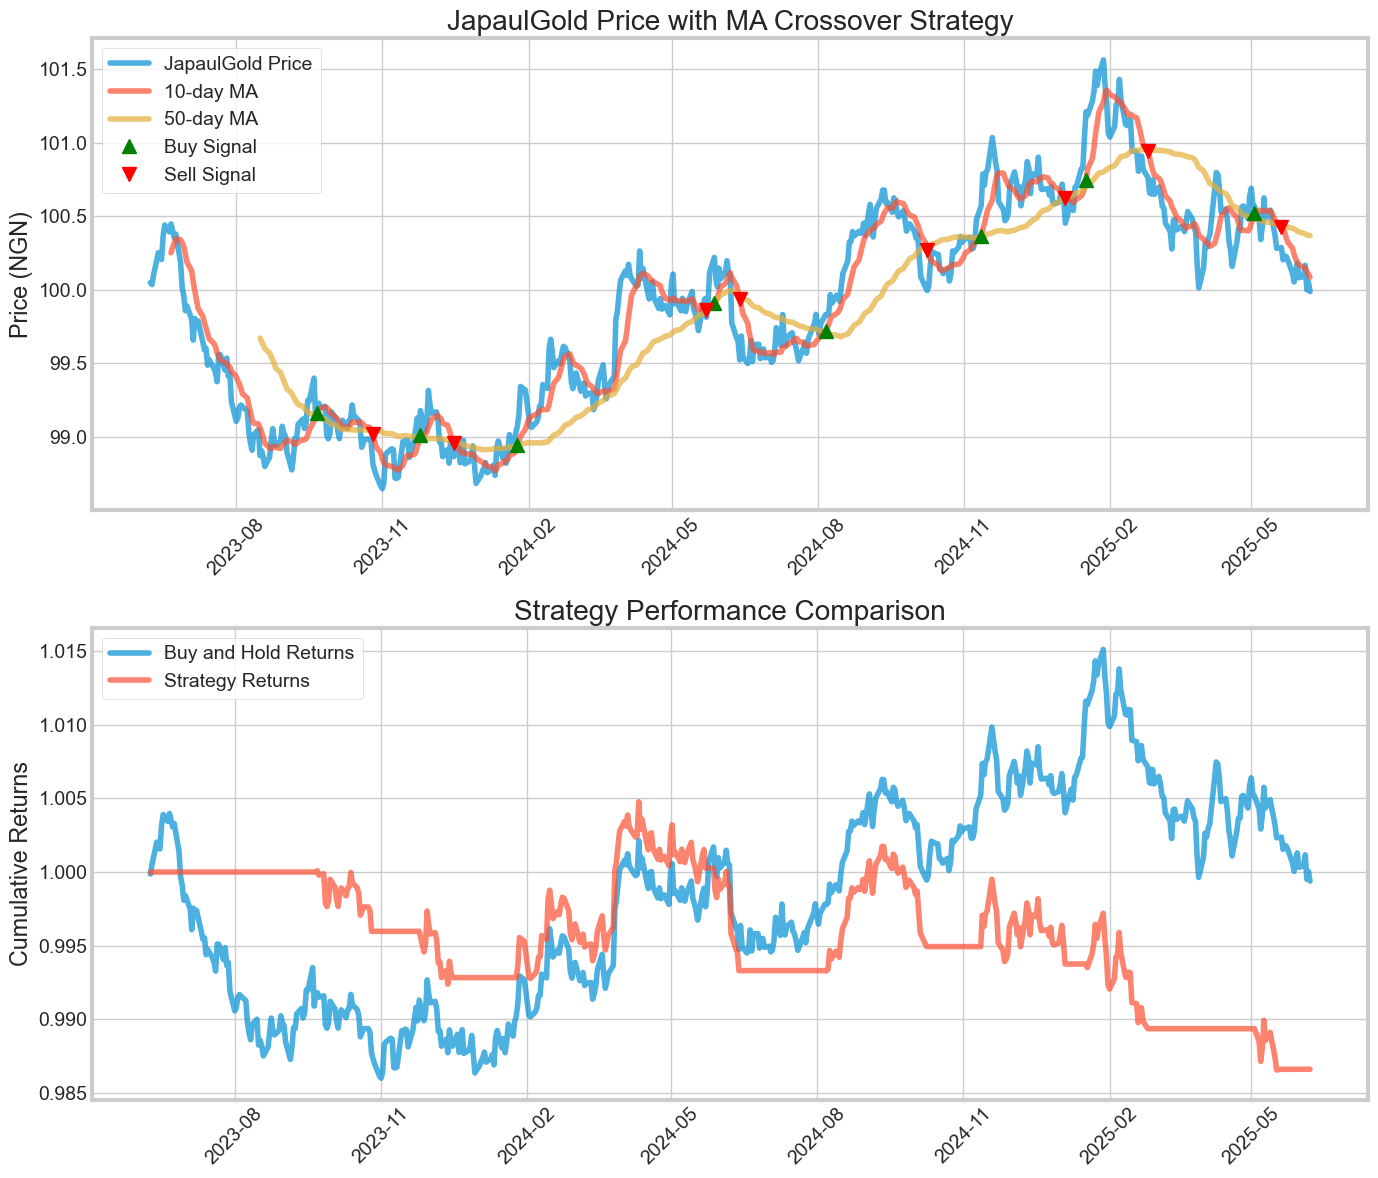

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import seaborn as sns

# Set the style for our plots
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

# Calculate the date range (2 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=2*365)

# Download JapaulGold data from NGX
# Note: For Nigerian stocks, we need to use the correct ticker symbol
# JapaulGold ticker on NGX might be "JAPAULGOLD.LG" or similar
try:
    # Try with the NGX extension
    ticker = "JAPAULGOLD.LG"
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # If no data is returned, we might need to use alternative data source
    if len(df) == 0:
        print("No data found with yfinance. In a real scenario, you would need to:")
        print("1. Use a different data provider that covers NGX")
        print("2. Import CSV data manually from a Nigerian broker")
        
        # Create sample data for demonstration purposes
        print("Creating sample data for demonstration...")
        dates = pd.date_range(start=start_date, end=end_date, freq='B')
        np.random.seed(42)
        price = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))/10
        df = pd.DataFrame({'Open': price*0.99, 'High': price*1.02, 
                          'Low': price*0.98, 'Close': price, 
                          'Adj Close': price, 'Volume': np.random.randint(100000, 1000000, len(dates))},
                         index=dates)
        print("Sample data created for demonstration")
except Exception as e:
    print(f"Error: {e}")
    # Create sample data as fallback
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    np.random.seed(42)
    price = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))/10
    df = pd.DataFrame({'Open': price*0.99, 'High': price*1.02, 
                      'Low': price*0.98, 'Close': price, 
                      'Adj Close': price, 'Volume': np.random.randint(100000, 1000000, len(dates))},
                     index=dates)
    print("Sample data created for demonstration")

# Calculate moving averages
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Generate trading signals
df['Signal'] = 0
df['Signal'] = np.where(df['MA10'] > df['MA50'], 1, 0)
df['Position'] = df['Signal'].diff()

# Calculate strategy returns
df['Returns'] = df['Close'].pct_change()
df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

# Calculate cumulative returns
df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()
df['Strategy_Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot price and moving averages
ax1.plot(df.index, df['Close'], label='JapaulGold Price', alpha=0.7)
ax1.plot(df.index, df['MA10'], label='10-day MA', alpha=0.7)
ax1.plot(df.index, df['MA50'], label='50-day MA', alpha=0.7)

# Plot buy/sell signals
ax1.plot(df[df['Position'] == 1].index, 
         df['MA10'][df['Position'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')
ax1.plot(df[df['Position'] == -1].index, 
         df['MA10'][df['Position'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')

ax1.set_title('JapaulGold Price with MA Crossover Strategy')
ax1.set_ylabel('Price (NGN)')
ax1.legend()
ax1.grid(True)

# Plot strategy performance
ax2.plot(df.index, df['Cumulative_Returns'], label='Buy and Hold Returns', alpha=0.7)
ax2.plot(df.index, df['Strategy_Cumulative_Returns'], label='Strategy Returns', alpha=0.7)
ax2.set_title('Strategy Performance Comparison')
ax2.set_ylabel('Cumulative Returns')
ax2.legend()
ax2.grid(True)

# Format x-axis dates
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()

# Calculate performance metrics
total_trades = df['Position'].abs().sum() / 2
winning_trades = df[(df['Position'] == -1) & (df['Strategy_Returns'] > 0)].shape[0]
if total_trades > 0:
    win_rate = winning_trades / total_trades
else:
    win_rate = 0
    
max_drawdown = (df['Strategy_Cumulative_Returns'] / df['Strategy_Cumulative_Returns'].cummax() - 1).min()
sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)

print(f"Performance Summary:")
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Final Strategy Return: {df['Strategy_Cumulative_Returns'].iloc[-1]:.2%}")
print(f"Buy & Hold Return: {df['Cumulative_Returns'].iloc[-1]:.2%}")

plt.show()

In [5]:
ax1.plot(df[df['Position'] == -1].index, 
         df['MA10'][df['Position'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')